# read data 

In [3]:
#merged_df.loc[(merged_df.category_2 == 'Dogs') | (merged_df.category_2 == 'Cats')].reset_index(drop = True).to_csv('dogs_cats_data.csv', index = False)

In [121]:
%matplotlib inline
import random
random.seed(1234)

import pandas as pd
import gzip
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# import nltk
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import spacy
import matplotlib.pyplot as plt
import pyLDAvis #python library for interactive topic model visualization
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# import warnings
# warnings.filterwarnings("ignore",category=DeprecationWarning)

import pickle
import numpy as np

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
# import pyLDAvis
# import pyLDAvis.sklearn
# import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm as tqdm
tqdm.pandas()

# Example for detecting bigrams 
import math
import nltk
from collections import defaultdict

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
from nltk.probability import FreqDist

from gensim.models.ldamulticore import LdaMulticore

In [2]:
df = pd.read_csv('recategorized_dogs_cats_data.csv', index_col = False)

In [3]:
df.loc[df.category_2 == 'Cats', ['category_3', 'final_category_4']].value_counts()

category_3                     final_category_4         
Food                           Wet                          3955
Beds & Furniture               Beds & Sofas                 2366
Toys                           Catnip Toys                  2268
Litter & Housebreaking         Litter Boxes                 2257
Toys                           Mice & Animal Toys           2091
Food                           Dry                          1961
Treats                         Snacks                       1578
Health Supplies                Relaxants                    1432
Litter & Housebreaking         Litter                       1242
Beds & Furniture               Activity Trees               1213
Toys                           Feather Toys                 1140
Beds & Furniture               Scratching Pads              1075
Health Supplies                Supplements & Vitamins       1072
                               Flea, Lice & Tick Control     708
Toys                           Ba

In [4]:
df1 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Food') & (df.final_category_4 == 'Wet')].reset_index(drop = True) 
df2 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Food') & (df.final_category_4 == 'Dry')].reset_index(drop = True)  #freshness

df3 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Beds & Furniture') & (df.final_category_4 == 'Beds & Sofas')]
df4 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Beds & Furniture') & (df.final_category_4 == 'Activity Trees')]
df5 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Beds & Furniture') & (df.final_category_4 == 'Scratching Pads')]

df6 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Litter & Housebreaking') & (df.final_category_4 == 'Litter')]
df7 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Litter & Housebreaking') & (df.final_category_4 == 'Litter Boxes')]

df8 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Toys') & (df.final_category_4 == 'Mice & Animal Toys')]
df9 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Toys') & (df.final_category_4 == 'Catnip Toys')]
df10 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Toys') & (df.final_category_4 == 'Feather Toys')]

df11 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Treats') & (df.final_category_4 == 'Snacks')]
df12 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Treats') & (df.final_category_4 == 'Snacks')]

df13 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Health Supplies') & (df.final_category_4 == 'Relaxants')]
df14 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Health Supplies') & (df.final_category_4 == 'Supplements & Vitamins')]

# Explore methodologies to prepare data

Methodologies:
- decide on which level of categories we wanna build topic modeling based on token frequencies (level 3 **check**)
- decide preprocess pipeline before feeding into ngram parser:
    - tokenize + punct removal + ngram 
    - tokenize + punct removal + ngram + lemmatize 
    - tokenize + punct removal + ngram + stopwords removal + lemmatize (**check**)

- compare ngram parser between `gensim.models.phrases` vs.s `nltk.collocations` (**check**)
    - `gensim` measure metrics: relative frequency. 
        - `gensim` parameter: `min_count`=5, `threshold=10`. `Threshold` = _(cnt(a, b) - min_count) * N / (cnt(a) * cnt(b))_
    - `nltk.collocations` measure metrics: pmi (**check**) or `raw_freq` (pmi/Pointwise Mutual Information: quantifies the discrepancy between the probability of their coincidence given their joint distribution and their individual distributions). 
    
- decide to keep certain tokens after pos tagging
    - ngram: adjective + noun (**check**)
    - unigram: adjective, noun, adverb, verb (**check**)

## level of category: compare between cat wet food v.s. cat dry food

In [142]:
reviews = df1.reviewText
reviews = df2.reviewText

## GENSIM.simple_preprocess(); gensim.models.phrases.Phraser(ngram)

In [209]:
def sent_to_words(sentences):
    '''
    Simplify and tokenize strings in an iterable.
    
            Parameters:
                    sentences (iterable): Review strings in a list or as a pandas.series.
                    
            Returns:
                    _ (generator): Simplify review tokens.  
    '''
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

def remove_stopwords(texts):
    '''
    Remove stopwords in an iterable (string or tokens).

        Parameters:
                texts (iterable): Review strings in a list or as a pandas.series.

        Returns:
                _ (list): Simplify review stirngs without stopwords.  
    '''
    stop_words = stopwords.words('english')
    return [[word for word in simple_preprocess(str(doc), deacc=True) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    '''
    Form bigrams.
    
        Parameters:
            texts (iterable): Review tokens in a list or as a pandas.series.

        Returns:
            _ (list): strings contain bigrams in a_b format.   
    '''
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=10) #train based on corpus
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    '''
    Form trigrams.
    
        Parameters:
            texts (iterable): Review tokens in a list or as a pandas.series.

        Returns:
            _ (list): strings contain trigrams in a_b_c format.   
    '''
    trigram = gensim.models.Phrases(bigram[data_words], threshold=10) #train based on corpus  
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))  
        if len(allowed_postags) > 0: 
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        else: 
            texts_out.append([token.lemma_ for token in doc])
    return texts_out

data_words = list(sent_to_words(tqdm(reviews.tolist())))
data_words_nostops = remove_stopwords(tqdm(data_words))
data_words_bigrams = make_bigrams(tqdm(data_words_nostops))
unigrams_lemmatized = lemmatization(tqdm(data_words_nostops), allowed_postags=['NOUN','ADJ', 'VERB', 'ADV'])
bigrams_lemmatized = lemmatization(tqdm(data_words_bigrams), allowed_postags=['NOUN','ADJ', 'VERB', 'ADV'])

  0%|          | 0/3955 [00:00<?, ?it/s]

  0%|          | 0/3955 [00:00<?, ?it/s]

  0%|          | 0/3955 [00:00<?, ?it/s]

  0%|          | 0/3955 [00:00<?, ?it/s]

  0%|          | 0/3955 [00:00<?, ?it/s]

## GENSIM: take one review as an example

In [211]:
reviews[714] 

'9 Lives Cat Food is one Meal my Cats really like and enjoy eating It. Daily Essentials Real Flaked Tuna in Sauce, one of the many Flavors that is Good for them and I get it Locally. 100% Completed and Balanced Nutrition with all kinds of Vitamins and Nutrients all supposed to be Good for Cats. I can get several Meals out of each Can of Food, my Cats are a little Finicky so I have to try different Flavors and Brands all the time. They enjoy eating it maybe twice a week, they don\'t eat a lot at one time, they are Nibblers and prefer to eat many little Meals. I have tried to give them other more expensive Cat Food from Popular "Specialty Pet Shops" or other "Food Boutiques" for Pets, however, they don\'t want any of that, they Crave and like eating 9 Lives. I am Glad there are such Diversity of Flavors to make my Cats Happy and to choose from. I even Feed 9 Lives to several Cats outside and they Love It! ...Thank You D.D.'

In [259]:
[" ".join(data_words[714])] 

['lives cat food is one meal my cats really like and enjoy eating it daily essentials real flaked tuna in sauce one of the many flavors that is good for them and get it locally completed and balanced nutrition with all kinds of vitamins and nutrients all supposed to be good for cats can get several meals out of each can of food my cats are little finicky so have to try different flavors and brands all the time they enjoy eating it maybe twice week they don eat lot at one time they are nibblers and prefer to eat many little meals have tried to give them other more expensive cat food from popular specialty pet shops or other food boutiques for pets however they don want any of that they crave and like eating lives am glad there are such diversity of flavors to make my cats happy and to choose from even feed lives to several cats outside and they love it thank you']

In [258]:
[" ".join(data_words_nostops[714])] 

['lives cat food one meal cats really like enjoy eating daily essentials real flaked tuna sauce one many flavors good get locally completed balanced nutrition kinds vitamins nutrients supposed good cats get several meals food cats little finicky try different flavors brands time enjoy eating maybe twice week eat lot one time nibblers prefer eat many little meals tried give expensive cat food popular specialty pet shops food boutiques pets however want crave like eating lives glad diversity flavors make cats happy choose even feed lives several cats outside love thank']

In [257]:
[" ".join(data_words_bigrams[714])] #enjoy_eate?  completed_balanced? 

['lives cat food one meal cats really like enjoy_eating daily essentials real flaked_tuna sauce one many_flavors good get_locally completed_balanced nutrition kinds_vitamins nutrients_supposed good cats get several_meals food cats little_finicky try_different flavors brands time enjoy_eating maybe twice_week eat lot one time_nibblers prefer eat many little_meals tried_give expensive cat food popular_specialty pet_shops food_boutiques pets_however want_crave like eating lives glad_diversity flavors_make cats happy_choose even feed lives several cats outside_love thank']

In [260]:
# doc = nlp(" ".join(data_words_bigrams[714]))  

# for token in doc: 
#     print(token.text, token.pos_, token.lemma_) #['NOUN','ADJ', 'VERB', 'ADV'] #and no PROUN 

In [256]:
[" ".join(unigrams_lemmatized[714])] #enjoy_eate?  completed_balanced? 

['live cat food meal cat really enjoy eat daily essential real flaked tuna sauce many flavor good get locally complete balanced nutrition kind vitamin nutrient suppose good cat get several meal food cat little finicky try different flavor brand time enjoy eat maybe twice week eat lot time nibbler prefer eat many little meal try give expensive cat food popular specialty pet shop food boutique pet however want crave eat life glad diversity flavor make cat happy choose even feed life several cat love thank']

In [255]:
[" ".join(bigrams_lemmatized[714])] #enjoy_eate?  completed_balanced? 

['live cat food meal cat really enjoy_eate daily essential real sauce many_flavor good get_locally completed_balanced nutrition kinds_vitamin nutrients_supposed good cat get food cat try_different flavor brand time enjoy_eate maybe twice_week eat lot time_nibbler prefer eat many little_meal tried_give expensive cat food popular_specialty pet_shop food_boutique want_crave eat life glad_diversity cat even feed life several cat thank']

## NLTK.collocations

In [143]:
def sent_to_words(sentences):
    '''
    Simplify and tokenize strings in an iterable.
    
            Parameters:
                    sentences (iterable): Review strings in a list or as a pandas.series.
                    
            Returns:
                    _ (generator): Simplify review tokens.  
    '''
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

def get_bigrams(data_words): 
    '''
    Form bigram.
    
        Parameters:
            data_words (iterable): Review tokens in a list or as a pandas.series.

        Returns:
           bigram_pmi (data frame): bigram and it's pmi score. 
    '''
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = nltk.collocations.BigramCollocationFinder.from_documents(data_words) #data_words_nostops
    finder.apply_freq_filter(20)
    bigram_scores = finder.score_ngrams(bigram_measures.pmi) 
    bigram_pmi = pd.DataFrame(bigram_scores)
    bigram_pmi.columns = ['bigram', 'pmi']
    bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)
    return finder, bigram_measures, bigram_pmi

def bigram_filter(bigram):
    """
    Filter bigram. 
        
        Parameters:
            bigram (string): a bigram.

        Returns:
           _ (boolean): decide whether or not to keep the bigram.
    """
    stop_words = stopwords.words('english')   
    tag = nltk.pos_tag(bigram)
    #if tag[0][1] not in ['JJ', 'NN', 'NNS'] and tag[1][1] not in ['NN', 'NNS']: #we only want adjective + noun
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']: #we only want adjective + noun
        return False
    if bigram[0] in stop_words or bigram[1] in stop_words: 
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram: #we don't want pronoun
        return False
    if len(bigram[0]) <= 2 or len(bigram[1]) <= 2:
        return False
    return True

def get_trigrams(data_words): 
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    finder = nltk.collocations.TrigramCollocationFinder.from_documents(data_words) #data_words_nostops
    finder.apply_freq_filter(20)
    trigram_scores = finder.score_ngrams(trigram_measures.pmi)

    trigram_pmi = pd.DataFrame(trigram_scores)
    trigram_pmi.columns = ['trigram', 'pmi']
    trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)
    return finder, trigram_measures, trigram_pmi

def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    stop_words = stopwords.words('english')
    #if tag[0][1] not in ['JJ', 'NN', 'NNS'] and tag[1][1] not in ['NN', 'NNS']: #we only want adjective + noun
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in stop_words or trigram[-1] in stop_words or trigram[1] in stop_words:
        return False
    if 'n' in trigram or 't' in trigram:
        return False
    if 'PRON' in trigram:
        return False
    if len(trigram[0]) <= 2 or len(trigram[1]) <= 2 and len(trigram[2]) <= 2:
        return False
    return True 

def replace_ngram(x, bigrams, trigrams):
    '''
    Form ngram. 
        
        Parameters:
            bigram (string): a bigram.

        Returns:
           _ (boolean): decide whether or not to keep the bigram.
    '''
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

def remove_stopwords(texts, extra_stopwords = []):
    '''
    Remove stopwords in an iterable (string or tokens).

        Parameters:
                texts (iterable): Review strings in a list or as a pandas.series.

        Returns:
                _ (list): Simplify review stirngs without stopwords.  
    '''
    stop_words = stopwords.words('english') + extra_stopwords
    return [[word for word in doc.split() if word not in stop_words] for doc in texts]

def lemmatize_skip_ngrams(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    '''feed tokens'''
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    texts_out = []
    for sent in texts:
        doc = nlp(' '.join(sent)) 
        if len(allowed_postags) > 0: 
            returned_doc = []
            for token in doc:
                if '_' in token.text:
                    returned_token = token.text
                if token.pos_ in allowed_postags and '_' not in token.text:
                    returned_token = token.lemma_
                if token.pos_ not in allowed_postags and '_' not in token.text:
                    continue
                returned_doc.append(returned_token)
            texts_out.append(returned_doc)
                    
        else: 
            returned_doc = []
            for token in doc:
                if '_' in token.text:
                    returned_token = token.text
                else: 
                    returned_token = token.lemma_
                returned_doc.append(returned_token)
            texts_out.append(returned_doc)
    return texts_out

data_words = list(sent_to_words(tqdm(reviews.tolist())))
bigram_finder, bigram_measures, bigram_pmi = get_bigrams(tqdm(data_words))
trigram_finder, trigram_measures, trigram_pmi = get_trigrams(tqdm(data_words))
filtered_bigram = bigram_pmi[bigram_pmi.progress_apply(lambda bigram:\
                                              bigram_filter(bigram['bigram'])\
                                              and bigram.pmi > 5, axis = 1)][:500]

filtered_trigram = trigram_pmi[trigram_pmi.progress_apply(lambda trigram: \
                                                 trigram_filter(trigram['trigram'])\
                                                 and trigram.pmi > 5, axis = 1)][:500]
bigrams = [' '.join(x) for x in filtered_bigram.bigram.values]
trigrams = [' '.join(x) for x in filtered_trigram.trigram.values]
reviews_ngrams = pd.DataFrame([' '.join(sen) for sen in data_words], columns = ['reviewText'])
reviews_ngrams.reviewText = reviews_ngrams.reviewText.map(lambda x: replace_ngram(x, bigrams, trigrams))
cleaned_reviews_ngrams = remove_stopwords(tqdm(reviews_ngrams.reviewText))
lemmatized_reviews_ngrams = lemmatize_skip_ngrams(tqdm(cleaned_reviews_ngrams), allowed_postags = [])

  0%|          | 0/5999 [00:00<?, ?it/s]

  0%|          | 0/5999 [00:00<?, ?it/s]

  0%|          | 0/5999 [00:00<?, ?it/s]

  0%|          | 0/3561 [00:00<?, ?it/s]

  0%|          | 0/1195 [00:00<?, ?it/s]

  0%|          | 0/5999 [00:00<?, ?it/s]

  0%|          | 0/5999 [00:00<?, ?it/s]

In [144]:
lemmatized_reviews_ngrams2 = lemmatize_skip_ngrams(tqdm(cleaned_reviews_ngrams), allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV'])

  0%|          | 0/5999 [00:00<?, ?it/s]

In [34]:
bigram_pmi.head(10)

,bigram,pmi
0,"(royal, canin)",12.546719
1,"(pro, plan)",11.743186
2,"(fancy, feast)",11.743186
3,"(urinary, tract)",11.023967
4,"(brown, rice)",10.963776
5,"(vitamin, supplement)",10.421220
6,"(nature, variety)",10.177776
7,"(ocean, fish)",10.045432
8,"(ideal, balance)",10.008215
9,"(picky, eaters)",9.806244


In [37]:
bigrams[:20]
filtered_bigram[:20]

,bigram,pmi
0,"(royal, canin)",12.546719
1,"(pro, plan)",11.743186
2,"(fancy, feast)",11.743186
3,"(urinary, tract)",11.023967
4,"(brown, rice)",10.963776
5,"(vitamin, supplement)",10.421220
6,"(nature, variety)",10.177776
7,"(ocean, fish)",10.045432
8,"(ideal, balance)",10.008215
9,"(picky, eaters)",9.806244


In [36]:
trigrams[:10]
filtered_trigram[:10]

,trigram,pmi
0,"(blue, buffalo, wilderness)",18.578908
2,"(hill, science, diet)",16.129572
11,"(year, old, cat)",12.679082
12,"(grain, free, diet)",12.652765
17,"(grain, free, dry)",11.958455
24,"(grain, free, cat)",11.236011
26,"(high, quality, food)",11.034184
27,"(grain, free, food)",10.892940
49,"(dry, cat, food)",9.156870
58,"(adult, cat, food)",8.761447


# NLTK: take one review as an example

In [146]:
# df2.loc[(df2.reviewerID == 'A1NJH2VUXKZMS5') & (df2.asin == 'B000084EXJ')] #23

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,related,...,categories,description,category_len,category_1,category_2,category_3,category_4,category_5,updated_category_4,final_category_4
44,A1NJH2VUXKZMS5,B000084EXJ,Dinda S. Evans,"[0, 0]",the price and size were right to donate to hum...,3,donated it to local humane society,1353369600,"11 20, 2012","{'also_bought': ['B002OIBZ6E', 'B000R4CJQ2', '...",...,"[['Pet Supplies', 'Cats', 'Food', 'Dry']]",SPORTMiX Gourmet Mix combines three flavors an...,4,Pet Supplies,Cats,Food,Dry,NaN,NaN,Dry


In [147]:
reviews[714] #wet food
reviews[44] #dry food

'the price and size were right to donate to humane society. My cats have refused to switch to purina or whiskas from Blue buffalo. I was seeking to reduce costs but just knew when I saw the big bag that there was no way my cats would eat it.  I had thought it was fancy feast...white cat...gourmet...so when I realized its just a cheaper brand than even the purina ....well. As a donation though it helps Im sure.. The dogs will eat it if the cats wont..at my place the racoons get whatever the cats reject.'

In [150]:
' '.join(data_words[44])

'the price and size were right to donate to humane society my cats have refused to switch to purina or whiskas from blue buffalo was seeking to reduce costs but just knew when saw the big bag that there was no way my cats would eat it had thought it was fancy feast white cat gourmet so when realized its just cheaper brand than even the purina well as donation though it helps im sure the dogs will eat it if the cats wont at my place the racoons get whatever the cats reject'

In [44]:
reviews_ngrams.loc[44, 'reviewText'] 

'the price and size were right to donate to humane society my cats have refused to switch to purina or whiskas from blue_buffalo was seeking to reduce costs but just knew when saw the big bag that there was no way my cats would eat it had thought it was fancy_feast white cat gourmet so when realized its just cheaper brand than even the purina well as donation though it helps im sure the dogs will eat it if the cats wont at my place the racoons get whatever the cats reject'

In [151]:
' '.join(cleaned_reviews_ngrams[44]) 

'price size right donate humane society cats refused switch purina whiskas blue_buffalo seeking reduce costs knew saw big_bag way cats would eat thought fancy_feast white cat gourmet realized cheaper brand even purina well donation though helps im sure dogs eat cats wont place racoons get whatever cats reject'

In [152]:
' '.join(lemmatized_reviews_ngrams[44]) 

'price size right donate humane society cat refuse switch purina whiskas blue_buffalo seek reduce cost know see big_bag way cat would eat think fancy_feast white cat gourmet realize cheap brand even purina well donation though help I m sure dog eat cat will not place racoon get whatever cat reject'

In [153]:
' '.join(lemmatized_reviews_ngrams2[44]) #m?

'price size right donate humane society cat refuse switch purina whiskas blue_buffalo seek reduce cost know see big_bag way cat eat think fancy_feast white cat gourmet realize cheap brand even well donation though help m sure dog eat cat place racoon get cat reject'

In [49]:
corpus = [word for sen in lemmatized_reviews_ngrams2 for word in sen]
fdist = FreqDist(corpus)
fdist.most_common(100)

In [51]:
sorted(trigram_finder.nbest(trigram_measures.raw_freq, 20))

[('cat', 'food', 'and'),
 ('cats', 'love', 'it'),
 ('cats', 'love', 'this'),
 ('dry', 'cat', 'food'),
 ('love', 'this', 'food'),
 ('my', 'cats', 'are'),
 ('my', 'cats', 'love'),
 ('of', 'cat', 'food'),
 ('of', 'my', 'cats'),
 ('of', 'the', 'wild'),
 ('of', 'this', 'food'),
 ('one', 'of', 'my'),
 ('one', 'of', 'the'),
 ('seem', 'to', 'like'),
 ('taste', 'of', 'the'),
 ('this', 'cat', 'food'),
 ('this', 'dry', 'food'),
 ('this', 'food', 'and'),
 ('this', 'food', 'is'),
 ('this', 'is', 'the')]

In [52]:
sorted(bigram_finder.nbest(bigram_measures.raw_freq, 20)) 

[('and', 'the'),
 ('and', 'they'),
 ('cat', 'food'),
 ('dry', 'food'),
 ('food', 'and'),
 ('for', 'the'),
 ('grain', 'free'),
 ('in', 'the'),
 ('it', 'is'),
 ('my', 'cat'),
 ('my', 'cats'),
 ('of', 'the'),
 ('on', 'the'),
 ('one', 'of'),
 ('the', 'cats'),
 ('the', 'food'),
 ('this', 'food'),
 ('this', 'is'),
 ('to', 'be'),
 ('to', 'the')]

# batch prepare data

In [54]:
df.loc[df.category_2 == 'Cats', ['category_3']].value_counts()

category_3                   
Toys                             7893
Food                             5999
Beds & Furniture                 5840
Litter & Housebreaking           4893
Health Supplies                  4294
Treats                           2237
Grooming                         1150
Feeding & Watering Supplies      1093
Educational Repellents            225
Cat Flaps, Steps, Nets & Pens     217
Collars, Harnesses & Leashes      193
Carriers & Strollers               88
Cages                              19
dtype: int64

In [55]:
df1 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Toys')]

df2 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Food')].reset_index(drop = True) 

df3 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Beds & Furniture')]

df4 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Litter & Housebreaking')]

df5 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Health Supplies')]

df6 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Treats')]

df7 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Grooming')]

df8 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Feeding & Watering Supplies ')]

In [74]:
df1 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Toys')]
df2 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Food')].reset_index(drop = True) 
df3 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Beds & Furniture')]
df4 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Litter & Housebreaking')]
df5 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Health Supplies')]
df6 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Treats')]
df7 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Grooming')]
df8 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Feeding & Watering Supplies')]

In [155]:
def sent_to_words(sentences):
    '''
    Simplify and tokenize strings in an iterable.
    
            Parameters:
                    sentences (iterable): Review strings in a list or as a pandas.series.
                    
            Returns:
                    _ (generator): Simplify review tokens.  
    '''
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

def get_bigrams(data_words): 
    '''
    Form bigram.
    
        Parameters:
            data_words (iterable): Review tokens in a list or as a pandas.series.

        Returns:
           bigram_pmi (data frame): bigram and it's pmi score. 
    '''
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = nltk.collocations.BigramCollocationFinder.from_documents(data_words) #data_words_nostops
    finder.apply_freq_filter(20)
    bigram_scores = finder.score_ngrams(bigram_measures.pmi) 
    bigram_pmi = pd.DataFrame(bigram_scores)
    bigram_pmi.columns = ['bigram', 'pmi']
    bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)
    return finder, bigram_measures, bigram_pmi

def bigram_filter(bigram):
    """
    Filter bigram. 
        
        Parameters:
            bigram (string): a bigram.

        Returns:
           _ (boolean): decide whether or not to keep the bigram.
    """
    stop_words = stopwords.words('english')   
    tag = nltk.pos_tag(bigram)
    #if tag[0][1] not in ['JJ', 'NN', 'NNS'] and tag[1][1] not in ['NN', 'NNS']: #we only want adjective + noun
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']: #we only want adjective + noun
        return False
    if bigram[0] in stop_words or bigram[1] in stop_words: 
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram: #we don't want pronoun
        return False
    if len(bigram[0]) <= 2 or len(bigram[1]) <= 2:
        return False
    return True

def get_trigrams(data_words): 
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    finder = nltk.collocations.TrigramCollocationFinder.from_documents(data_words) #data_words_nostops
    finder.apply_freq_filter(20)
    trigram_scores = finder.score_ngrams(trigram_measures.pmi)

    trigram_pmi = pd.DataFrame(trigram_scores)
    trigram_pmi.columns = ['trigram', 'pmi']
    trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)
    return finder, trigram_measures, trigram_pmi

def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    stop_words = stopwords.words('english')
    #if tag[0][1] not in ['JJ', 'NN', 'NNS'] and tag[1][1] not in ['NN', 'NNS']: #we only want adjective + noun
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in stop_words or trigram[-1] in stop_words or trigram[1] in stop_words:
        return False
    if 'n' in trigram or 't' in trigram:
        return False
    if 'PRON' in trigram:
        return False
    if len(trigram[0]) <= 2 or len(trigram[1]) <= 2 and len(trigram[2]) <= 2:
        return False
    return True 

def replace_ngram(x, bigrams, trigrams):
    '''
    Form ngram. 
        
        Parameters:
            bigram (string): a bigram.

        Returns:
           _ (boolean): decide whether or not to keep the bigram.
    '''
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x


def remove_stopwords(texts, extra_stopwords = []):
    '''
    Remove stopwords in an iterable (string or tokens).

        Parameters:
                texts (iterable): Review strings in a list or as a pandas.series.

        Returns:
                _ (list): Simplify review stirngs without stopwords.  
    '''
    stop_words = stopwords.words('english') + extra_stopwords
    return [[word for word in doc.split() if word not in stop_words] for doc in texts]

def lemmatize_skip_ngrams(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    '''feed tokens'''
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    texts_out = []
    for sent in texts:
        doc = nlp(' '.join(sent)) 
        if len(allowed_postags) > 0: 
            returned_doc = []
            for token in doc:
                if '_' in token.text:
                    returned_token = token.text
                if token.pos_ in allowed_postags and '_' not in token.text:
                    returned_token = token.lemma_
                if token.pos_ not in allowed_postags and '_' not in token.text:
                    continue
                returned_doc.append(returned_token)
            texts_out.append(returned_doc)
                    
        else: 
            returned_doc = []
            for token in doc:
                if '_' in token.text:
                    returned_token = token.text
                else: 
                    returned_token = token.lemma_
                returned_doc.append(returned_token)
            texts_out.append(returned_doc)
    return texts_out

def preprocess_review(reviews, extra_stopwords = ['cat', 'cats'], allowed_postags=[]): 
    
    data_words = list(sent_to_words(tqdm(reviews.tolist())))
    bigram_finder, bigram_measures, bigram_pmi = get_bigrams(tqdm(data_words))
    trigram_finder, trigram_measures, trigram_pmi = get_trigrams(tqdm(data_words))
    filtered_bigram = bigram_pmi[bigram_pmi.progress_apply(lambda bigram:\
                                                  bigram_filter(bigram['bigram'])\
                                                  and bigram.pmi > 5, axis = 1)][:500]

    filtered_trigram = trigram_pmi[trigram_pmi.progress_apply(lambda trigram: \
                                                     trigram_filter(trigram['trigram'])\
                                                     and trigram.pmi > 5, axis = 1)][:500]
    bigrams = [' '.join(x) for x in filtered_bigram.bigram.values]
    trigrams = [' '.join(x) for x in filtered_trigram.trigram.values]
    reviews_ngrams = pd.DataFrame([' '.join(sen) for sen in data_words], columns = ['reviewText'])
    reviews_ngrams.reviewText = reviews_ngrams.reviewText.map(lambda x: replace_ngram(x, bigrams, trigrams))
    cleaned_reviews_ngrams = remove_stopwords(tqdm(reviews_ngrams.reviewText), extra_stopwords = extra_stopwords)
    lemmatized_reviews_ngrams = lemmatize_skip_ngrams(tqdm(cleaned_reviews_ngrams), allowed_postags = allowed_postags)
    return filtered_bigram, filtered_trigram, lemmatized_reviews_ngrams

In [75]:
df8.shape

(1093, 25)

In [82]:
cats_toys_bigram, cats_toys_trigram, cats_toys_reviews = preprocess_review(df1.reviewText, extra_stopwords = ['cat', 'cats', 'toy', 'toys'])
cats_food_bigram, cats_food_trigram, cats_food_reviews = preprocess_review(df2.reviewText, extra_stopwords = ['cat', 'cats', 'food'])
cats_beds_bigram, cats_beds_trigram, cats_beds_reviews = preprocess_review(df3.reviewText, extra_stopwords = ['cat', 'cats', 'bed', 'beds'] )
cats_litter_bigram, cats_litter_trigram, cats_litter_reviews = preprocess_review(df4.reviewText, extra_stopwords = ['cat', 'cats', 'litters', 'litter'])
cats_health_supplies_bigram, cats_health_supplies_trigram, cats_health_supplies_reviews = preprocess_review(df5.reviewText, extra_stopwords = ['cat', 'cats'])
cats_treats_bigram, cats_treats_trigram, cats_treats_reviews = preprocess_review(df6.reviewText, extra_stopwords = ['cat', 'cats', 'treat', 'treats'])
cats_grooming_bigram, cats_grooming_trigram, cats_grooming_reviews = preprocess_review(df7.reviewText, extra_stopwords = ['cat', 'cats'])
cats_feeding_supplies_bigram, cats_feeding_suppliess_trigram, cats_feeding_supplies_reviews = preprocess_review(df8.reviewText, extra_stopwords = ['cat', 'cats'])

  0%|          | 0/7893 [00:00<?, ?it/s]

  0%|          | 0/7893 [00:00<?, ?it/s]

  0%|          | 0/7893 [00:00<?, ?it/s]

  0%|          | 0/3745 [00:00<?, ?it/s]

  0%|          | 0/1269 [00:00<?, ?it/s]

  0%|          | 0/7893 [00:00<?, ?it/s]

  0%|          | 0/7893 [00:00<?, ?it/s]

  0%|          | 0/5999 [00:00<?, ?it/s]

  0%|          | 0/5999 [00:00<?, ?it/s]

  0%|          | 0/5999 [00:00<?, ?it/s]

  0%|          | 0/3561 [00:00<?, ?it/s]

  0%|          | 0/1195 [00:00<?, ?it/s]

  0%|          | 0/5999 [00:00<?, ?it/s]

  0%|          | 0/5999 [00:00<?, ?it/s]

  0%|          | 0/5840 [00:00<?, ?it/s]

  0%|          | 0/5840 [00:00<?, ?it/s]

  0%|          | 0/5840 [00:00<?, ?it/s]

  0%|          | 0/3445 [00:00<?, ?it/s]

  0%|          | 0/1059 [00:00<?, ?it/s]

  0%|          | 0/5840 [00:00<?, ?it/s]

  0%|          | 0/5840 [00:00<?, ?it/s]

  0%|          | 0/4893 [00:00<?, ?it/s]

  0%|          | 0/4893 [00:00<?, ?it/s]

  0%|          | 0/4893 [00:00<?, ?it/s]

  0%|          | 0/3742 [00:00<?, ?it/s]

  0%|          | 0/1154 [00:00<?, ?it/s]

  0%|          | 0/4893 [00:00<?, ?it/s]

  0%|          | 0/4893 [00:00<?, ?it/s]

  0%|          | 0/4294 [00:00<?, ?it/s]

  0%|          | 0/4294 [00:00<?, ?it/s]

  0%|          | 0/4294 [00:00<?, ?it/s]

  0%|          | 0/2248 [00:00<?, ?it/s]

  0%|          | 0/427 [00:00<?, ?it/s]

  0%|          | 0/4294 [00:00<?, ?it/s]

  0%|          | 0/4294 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/826 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/1150 [00:00<?, ?it/s]

  0%|          | 0/1150 [00:00<?, ?it/s]

  0%|          | 0/1150 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/1150 [00:00<?, ?it/s]

  0%|          | 0/1150 [00:00<?, ?it/s]

  0%|          | 0/1093 [00:00<?, ?it/s]

  0%|          | 0/1093 [00:00<?, ?it/s]

  0%|          | 0/1093 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/1093 [00:00<?, ?it/s]

  0%|          | 0/1093 [00:00<?, ?it/s]

In [287]:
cats_toys_bigram, cats_toys_trigram, cats_toys_reviews2 = preprocess_review(df1.reviewText, extra_stopwords = ['cat', 'cats', 'toy', 'toys'],
                                                                          allowed_postags = ['ADJ', 'VERB', 'ADV'])
cats_food_bigram, cats_food_trigram, cats_food_reviews2 = preprocess_review(df2.reviewText, extra_stopwords = ['cat', 'cats', 'food'],
                                                                          allowed_postags = ['ADJ', 'VERB', 'ADV'])
cats_beds_bigram, cats_beds_trigram, cats_beds_reviews2 = preprocess_review(df3.reviewText, extra_stopwords = ['cat', 'cats', 'bed', 'beds'],
                                                                          allowed_postags = ['ADJ', 'VERB', 'ADV'])
cats_litter_bigram, cats_litter_trigram, cats_litter_reviews2 = preprocess_review(df4.reviewText, extra_stopwords = ['cat', 'cats', 'litters', 'litter'],
                                                                                allowed_postags = ['ADJ', 'VERB', 'ADV'])
cats_health_supplies_bigram, cats_health_supplies_trigram, cats_health_supplies_reviews2 = preprocess_review(df5.reviewText, extra_stopwords = ['cat', 'cats'],
                                                                                                           allowed_postags = ['ADJ', 'VERB', 'ADV'])
cats_treats_bigram, cats_treats_trigram, cats_treats_reviews2 = preprocess_review(df6.reviewText, extra_stopwords = ['cat', 'cats', 'treat', 'treats'],
                                                                                allowed_postags = ['ADJ', 'VERB', 'ADV'])
cats_grooming_bigram, cats_grooming_trigram, cats_grooming_reviews2 = preprocess_review(df7.reviewText, extra_stopwords = ['cat', 'cats'],
                                                                                      allowed_postags = ['ADJ', 'VERB', 'ADV'])
cats_feeding_supplies_bigram, cats_feeding_suppliess_trigram, cats_feeding_supplies_reviews2 = preprocess_review(df8.reviewText, extra_stopwords = ['cat', 'cats'],
                                                                                                               allowed_postags = ['ADJ', 'VERB', 'ADV'])

  0%|          | 0/7893 [00:00<?, ?it/s]

  0%|          | 0/7893 [00:00<?, ?it/s]

  0%|          | 0/7893 [00:00<?, ?it/s]

  0%|          | 0/3745 [00:00<?, ?it/s]

  0%|          | 0/1269 [00:00<?, ?it/s]

  0%|          | 0/7893 [00:00<?, ?it/s]

  0%|          | 0/7893 [00:00<?, ?it/s]

  0%|          | 0/5999 [00:00<?, ?it/s]

  0%|          | 0/5999 [00:00<?, ?it/s]

  0%|          | 0/5999 [00:00<?, ?it/s]

  0%|          | 0/3561 [00:00<?, ?it/s]

  0%|          | 0/1195 [00:00<?, ?it/s]

  0%|          | 0/5999 [00:00<?, ?it/s]

  0%|          | 0/5999 [00:00<?, ?it/s]

  0%|          | 0/5840 [00:00<?, ?it/s]

  0%|          | 0/5840 [00:00<?, ?it/s]

  0%|          | 0/5840 [00:00<?, ?it/s]

  0%|          | 0/3445 [00:00<?, ?it/s]

  0%|          | 0/1059 [00:00<?, ?it/s]

  0%|          | 0/5840 [00:00<?, ?it/s]

  0%|          | 0/5840 [00:00<?, ?it/s]

  0%|          | 0/4893 [00:00<?, ?it/s]

  0%|          | 0/4893 [00:00<?, ?it/s]

  0%|          | 0/4893 [00:00<?, ?it/s]

  0%|          | 0/3742 [00:00<?, ?it/s]

  0%|          | 0/1154 [00:00<?, ?it/s]

  0%|          | 0/4893 [00:00<?, ?it/s]

  0%|          | 0/4893 [00:00<?, ?it/s]

  0%|          | 0/4294 [00:00<?, ?it/s]

  0%|          | 0/4294 [00:00<?, ?it/s]

  0%|          | 0/4294 [00:00<?, ?it/s]

  0%|          | 0/2248 [00:00<?, ?it/s]

  0%|          | 0/427 [00:00<?, ?it/s]

  0%|          | 0/4294 [00:00<?, ?it/s]

  0%|          | 0/4294 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/826 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/1150 [00:00<?, ?it/s]

  0%|          | 0/1150 [00:00<?, ?it/s]

  0%|          | 0/1150 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/1150 [00:00<?, ?it/s]

  0%|          | 0/1150 [00:00<?, ?it/s]

  0%|          | 0/1093 [00:00<?, ?it/s]

  0%|          | 0/1093 [00:00<?, ?it/s]

  0%|          | 0/1093 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/1093 [00:00<?, ?it/s]

  0%|          | 0/1093 [00:00<?, ?it/s]

In [88]:
cats_health_supplies_bigram[:20]

,bigram,pmi
0,"(maine, coon)",13.269454
1,"(hyaluronic, acid)",12.465851
2,"(vetri, science)",11.822090
3,"(herpes, virus)",11.817771
4,"(urinary, tract)",11.552751
5,"(comfort, zone)",11.045878
6,"(plug, ins)",10.905827
7,"(salmon, oil)",10.575949
8,"(side, effects)",10.479255
9,"(pill, pockets)",10.408671


# modeling

In [123]:
def vectorize(texts):
    dictionary = corpora.Dictionary(tqdm(texts))
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in tqdm(texts)]
    return dictionary, doc_term_matrix

In [285]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print('Round: '+ str(num_topics))
        model = LdaMulticore(corpus=corpus, 
                                num_topics=num_topics, 
                                id2word=dictionary,
                                passes=40,
                                iterations=10, 
                                chunksize = 100, 
                                eval_every = None,
                                random_state = 1234)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, 
                                        texts=texts, 
                                        dictionary=dictionary, 
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

def get_keywords(doc_term_matrix, model): #top 20
    keywords_dict = {}
    for k in range(len(model.top_topics(doc_term_matrix))):
        tu = model.top_topics(doc_term_matrix)[k]
        keywords_lst = []
        for tup in tu[0]:
            keywords_lst.append(tup[1])
        keywords_dict[k] = keywords_lst
    return keywords_dict

## 1. cats feeding supplies

In [400]:
cats_feeding_supplies_dictionary, cats_feeding_supplies_doc_term_matrix = vectorize(cats_feeding_supplies_reviews2)
cats_feeding_supplies_model_list, cats_feeding_supplies_coherence_values = compute_coherence_values(
                                                    dictionary=cats_feeding_supplies_dictionary, 
                                                    corpus=cats_feeding_supplies_doc_term_matrix, 
                                                    texts=cats_feeding_supplies_reviews2, 
                                                    start=2, 
                                                    limit=20, 
                                                    step=2)

limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, cats_feeding_supplies_coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
for m, cv in zip(x, cats_feeding_supplies_coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    
with open ('./cat_feeding_supplies_model_list.pickle', 'wb') as handle:
    pickle.dump(cats_feeding_supplies_model_list, handle)

  0%|          | 0/1093 [00:00<?, ?it/s]

  0%|          | 0/1093 [00:00<?, ?it/s]

Round: 2


KeyboardInterrupt: 

In [ ]:
# with open ('./cat_feeding_supplies_model_list.pickle', 'rb') as handle:
#     model_list2 = pickle.load(handle)

In [ ]:
cats_feeding_supplies_optimal_model = cats_feeding_supplies_model_list[3]
model_topics = cats_feeding_supplies_optimal_model.show_topics(formatted=False)

In [112]:
cats_feeding_supplies_optimal_model.print_topics(num_topics=8, num_words=6) #too many noun. maybe remove nouns

[(0,
  '0.042*"food" + 0.025*"ball" + 0.019*"get" + 0.014*"hole" + 0.014*"treat" + 0.014*"use"'),
 (1,
  '0.017*"get" + 0.015*"like" + 0.010*"ball" + 0.009*"bowl" + 0.009*"eat" + 0.009*"little"'),
 (2,
  '0.046*"water" + 0.030*"fountain" + 0.018*"filter" + 0.016*"drink" + 0.016*"clean" + 0.015*"use"'),
 (3,
  '0.070*"bowl" + 0.038*"dish" + 0.014*"bottom" + 0.013*"like" + 0.011*"easy" + 0.011*"eat"'),
 (4,
  '0.032*"pump" + 0.019*"water" + 0.019*"fountain" + 0.017*"one" + 0.012*"bowl" + 0.011*"clean"'),
 (5,
  '0.029*"water" + 0.022*"bowl" + 0.017*"filter" + 0.012*"get" + 0.010*"pet" + 0.010*"one"'),
 (6,
  '0.036*"grass" + 0.020*"grow" + 0.014*"like" + 0.011*"seed" + 0.011*"would" + 0.008*"buy"'),
 (7,
  '0.019*"feeder" + 0.018*"food" + 0.015*"time" + 0.014*"one" + 0.013*"get" + 0.012*"feed"')]

In [177]:
pyLDAvis.enable_notebook()
topic_data =  pyLDAvis.gensim_models.prepare(cats_feeding_supplies_optimal_model, 
                                             cats_feeding_supplies_doc_term_matrix, 
                                             cats_feeding_supplies_dictionary, 
                                             mds = 'tsne')
pyLDAvis.display(topic_data)

# pcoa:Principal Coordinate Analysis(aka Classical Multidimensional Scaling)
# mmds:Metric Multidimensional Scaling
# tsne:t-distributed Stochastic Neighbor Embedding

C:\Users\JiatingChen\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


In [ ]:
[w for w in keywords_dict[0] if w not in  keywords_dict[1] and w not in  keywords_dict[2] and w not in  keywords_dict[3]]

In [374]:
[w for w in keywords_dict[1] if w not in  keywords_dict[0] and w not in  keywords_dict[2] and w not in  keywords_dict[3]]

['quiet', 'new', 'run', 'fresh']

In [375]:
[w for w in keywords_dict[2] if w not in  keywords_dict[1] and w not in  keywords_dict[0] and w not in  keywords_dict[3]]

['nice', 'grow', 'recommend', 'bowl']

In [376]:
[w for w in keywords_dict[3] if w not in  keywords_dict[1] and w not in  keywords_dict[2] and w not in  keywords_dict[0]]

['set', 'large', 'leave', 'see', 'extra', 'want', 'hard']

In [377]:
pyLDAvis.enable_notebook()
topic_data =  pyLDAvis.gensim_models.prepare(cat_feeding_supplies_optimal_model, 
                                             cats_feeding_supplies_doc_term_matrix2, 
                                             cats_feeding_supplies_dictionary2, 
                                             mds = 'tsne')
pyLDAvis.display(topic_data)

C:\Users\JiatingChen\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
C:\Users\JiatingChen\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


## 2. cat food (2/4)

In [185]:
cats_food_bigram, cats_food_trigram, cats_food_reviews2 = preprocess_review(df2.reviewText, 
                                                         extra_stopwords = ['cat', 'cats', 'food'],
                                                         allowed_postags = ['ADJ', 'VERB', 'ADV'])

  0%|          | 0/5999 [00:00<?, ?it/s]

  0%|          | 0/5999 [00:00<?, ?it/s]

  0%|          | 0/5999 [00:00<?, ?it/s]

  0%|          | 0/3561 [00:00<?, ?it/s]

  0%|          | 0/1195 [00:00<?, ?it/s]

  0%|          | 0/5999 [00:00<?, ?it/s]

  0%|          | 0/5999 [00:00<?, ?it/s]

  0%|          | 0/5999 [00:00<?, ?it/s]

  0%|          | 0/5999 [00:00<?, ?it/s]

Round: 2
Round: 4
Round: 6
Round: 8
Round: 10
Round: 12
Round: 14
Round: 16
Round: 18


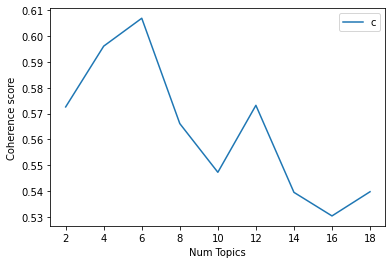

Num Topics = 2  has Coherence Value of 0.5726
Num Topics = 4  has Coherence Value of 0.5961
Num Topics = 6  has Coherence Value of 0.6069
Num Topics = 8  has Coherence Value of 0.5661
Num Topics = 10  has Coherence Value of 0.5473
Num Topics = 12  has Coherence Value of 0.5732
Num Topics = 14  has Coherence Value of 0.5395
Num Topics = 16  has Coherence Value of 0.5304
Num Topics = 18  has Coherence Value of 0.5398


In [341]:
cats_food_dictionary, cats_food_doc_term_matrix = vectorize(cats_food_reviews2)
model_list, coherence_values = compute_coherence_values(dictionary=cats_food_dictionary, 
                                                    corpus=cats_food_doc_term_matrix, 
                                                    texts=cats_food_reviews2, 
                                                    start=2, 
                                                    limit=20, 
                                                    step=2)

limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [342]:
with open ('./cat_food_model_list.pickle', 'wb') as handle:
    pickle.dump(model_list, handle)

In [379]:
with open ('./cat_food_model_list.pickle', 'rb') as handle:
    model_list = pickle.load(handle)

In [380]:
cat_food_optimal_model = model_list[1]
model_topics = cat_food_optimal_model.show_topics(formatted=False)

In [381]:
cat_food_optimal_model.print_topics(num_topics=4, num_words=30)

[(0,
  '0.060*"eat" + 0.024*"get" + 0.019*"try" + 0.017*"seem" + 0.016*"go" + 0.013*"give" + 0.013*"much" + 0.012*"good" + 0.011*"look" + 0.011*"well" + 0.010*"really" + 0.010*"think" + 0.010*"even" + 0.010*"make" + 0.010*"say" + 0.009*"know" + 0.009*"open" + 0.009*"smell" + 0.009*"first" + 0.009*"come" + 0.009*"love" + 0.009*"put" + 0.008*"see" + 0.008*"never" + 0.008*"like" + 0.008*"buy" + 0.007*"old" + 0.007*"little" + 0.007*"picky" + 0.007*"want"'),
 (1,
  '0.022*"good" + 0.022*"well" + 0.019*"get" + 0.016*"healthy" + 0.016*"love" + 0.014*"buy" + 0.013*"much" + 0.013*"try" + 0.012*"seem" + 0.012*"give" + 0.012*"find" + 0.012*"recommend" + 0.011*"feed" + 0.011*"also" + 0.010*"eat" + 0.010*"switch" + 0.010*"expensive" + 0.009*"grain_free" + 0.009*"less" + 0.009*"use" + 0.009*"make" + 0.008*"go" + 0.008*"really" + 0.008*"old" + 0.008*"dry" + 0.007*"even" + 0.007*"great" + 0.007*"little" + 0.007*"cheap" + 0.007*"start"'),
 (2,
  '0.034*"dry" + 0.025*"eat" + 0.025*"fancy_feast" + 0.021*

In [382]:
keywords_dict = get_keywords(cats_food_doc_term_matrix, model = cat_food_optimal_model)

In [388]:
# keywords_dict #2 and 3 are swamped

In [383]:
[w for w in keywords_dict[0] if w not in  keywords_dict[1] and w not in  keywords_dict[2] and w not in  keywords_dict[3]]

['think', 'even', 'open', 'smell', 'first', 'come']

In [384]:
[w for w in keywords_dict[1] if w not in  keywords_dict[0] and w not in  keywords_dict[2] and w not in  keywords_dict[3]] #cheap price

['buy', 'find', 'recommend', 'switch', 'expensive', 'grain_free', 'less']

In [385]:
[w for w in keywords_dict[2] if w not in keywords_dict[0] and w not in  keywords_dict[1] and w not in keywords_dict[3]] #health

['natural', 'contain', 'high', 'pet', 'include', 'low', 'see', 'mean']

In [386]:
[w for w in keywords_dict[3] if w not in  keywords_dict[0] and w not in  keywords_dict[1] and w not in  keywords_dict[2]]

['fancy_feast',
 'wet',
 'can',
 'like',
 'keep',
 'prefer',
 'enjoy',
 'happy',
 'favorite',
 'great']

In [368]:
pyLDAvis.enable_notebook()
topic_data =  pyLDAvis.gensim_models.prepare(optimal_model, 
                                             cats_food_doc_term_matrix, 
                                             cats_food_dictionary, 
                                             mds = 'tsne')
pyLDAvis.display(topic_data)

C:\Users\JiatingChen\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
C:\Users\JiatingChen\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


## 3. cat toys (0/4)

  0%|          | 0/7893 [00:00<?, ?it/s]

  0%|          | 0/7893 [00:00<?, ?it/s]

Round: 2
Round: 4
Round: 6
Round: 8
Round: 10
Round: 12
Round: 14
Round: 16
Round: 18


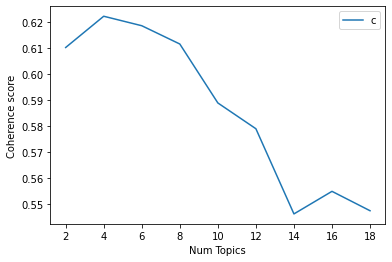

Num Topics = 2  has Coherence Value of 0.6101
Num Topics = 4  has Coherence Value of 0.6221
Num Topics = 6  has Coherence Value of 0.6184
Num Topics = 8  has Coherence Value of 0.6114
Num Topics = 10  has Coherence Value of 0.5888
Num Topics = 12  has Coherence Value of 0.5788
Num Topics = 14  has Coherence Value of 0.5461
Num Topics = 16  has Coherence Value of 0.5548
Num Topics = 18  has Coherence Value of 0.5473


In [289]:
cats_toys_dictionary, cats_toys_doc_term_matrix = vectorize(cats_toys_reviews2)
model_list, coherence_values = compute_coherence_values(dictionary=cats_toys_dictionary, 
                                                    corpus=cats_toys_doc_term_matrix, 
                                                    texts=cats_toys_reviews2, 
                                                    start=2, 
                                                    limit=20, 
                                                    step=2)

limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    
# with open ('./cat_toys_model_list.pickle', 'wb') as handle:
#     pickle.dump(model_list, handle)

In [292]:
with open ('./cat_toys_model_list.pickle', 'rb') as handle:
     model_list = pickle.load(handle)

In [295]:
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
keywords_dict = get_keywords(cats_toys_doc_term_matrix, model = optimal_model)
optimal_model.print_topics(num_topics=4, num_words=30)

[(0,
  '0.044*"buy" + 0.027*"love" + 0.025*"get" + 0.016*"old" + 0.016*"catnip" + 0.014*"good" + 0.013*"play" + 0.012*"recommend" + 0.012*"well" + 0.011*"great" + 0.011*"little" + 0.011*"find" + 0.011*"happy" + 0.011*"still" + 0.010*"purchase" + 0.009*"even" + 0.009*"new" + 0.009*"make" + 0.009*"last" + 0.008*"keep" + 0.008*"come" + 0.008*"small" + 0.007*"use" + 0.007*"always" + 0.007*"highly" + 0.006*"lose" + 0.006*"much" + 0.006*"carry" + 0.006*"order" + 0.006*"hold"'),
 (1,
  '0.051*"love" + 0.041*"go" + 0.037*"play" + 0.029*"get" + 0.016*"make" + 0.016*"crazy" + 0.016*"much" + 0.014*"great" + 0.012*"favorite" + 0.011*"well" + 0.011*"little" + 0.010*"never" + 0.010*"even" + 0.010*"know" + 0.009*"give" + 0.009*"think" + 0.008*"see" + 0.008*"really" + 0.008*"chase" + 0.008*"around" + 0.007*"look" + 0.007*"absolutely" + 0.007*"also" + 0.006*"say" + 0.006*"worth" + 0.006*"good" + 0.006*"fly" + 0.006*"carry" + 0.006*"run" + 0.006*"sure"'),
 (2,
  '0.028*"make" + 0.027*"seem" + 0.023*"wel

In [296]:
[w for w in keywords_dict[0] if w not in  keywords_dict[1] and w not in  keywords_dict[2] and w not in  keywords_dict[3]]

['put', 'try', 'back', 'away', 'take', 'use', 'want', 'together']

In [298]:
[w for w in keywords_dict[1] if w not in  keywords_dict[0] and w not in  keywords_dict[2] and w not in  keywords_dict[3]]

['buy',
 'old',
 'catnip',
 'recommend',
 'find',
 'happy',
 'purchase',
 'new',
 'last']

In [299]:
[w for w in keywords_dict[2] if w not in  keywords_dict[0] and w not in  keywords_dict[1] and w not in  keywords_dict[3]]

['crazy', 'favorite', 'never', 'know', 'chase', 'around']

In [300]:
[w for w in keywords_dict[3] if w not in  keywords_dict[0] and w not in  keywords_dict[2] and w not in  keywords_dict[1]]

['seem', 'like', 'long', 'also', 'small', 'enjoy', 'break', 'nice', 'maybe']

In [294]:
pyLDAvis.enable_notebook()
topic_data =  pyLDAvis.gensim_models.prepare(optimal_model, 
                                             cats_toys_doc_term_matrix, 
                                             cats_toys_dictionary, 
                                             mds = 'tsne')
pyLDAvis.display(topic_data)

C:\Users\JiatingChen\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
C:\Users\JiatingChen\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


## 4. cats beds (4/6)

  0%|          | 0/5840 [00:00<?, ?it/s]

  0%|          | 0/5840 [00:00<?, ?it/s]

Round: 2
Round: 4
Round: 6
Round: 8
Round: 10
Round: 12
Round: 14
Round: 16
Round: 18


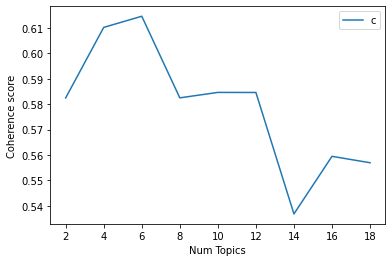

Num Topics = 2  has Coherence Value of 0.5824
Num Topics = 4  has Coherence Value of 0.6102
Num Topics = 6  has Coherence Value of 0.6146
Num Topics = 8  has Coherence Value of 0.5825
Num Topics = 10  has Coherence Value of 0.5846
Num Topics = 12  has Coherence Value of 0.5846
Num Topics = 14  has Coherence Value of 0.5368
Num Topics = 16  has Coherence Value of 0.5594
Num Topics = 18  has Coherence Value of 0.5569


In [290]:
cats_beds_dictionary, cats_beds_doc_term_matrix = vectorize(cats_beds_reviews2)
model_list, coherence_values = compute_coherence_values(dictionary=cats_beds_dictionary, 
                                                    corpus=cats_beds_doc_term_matrix, 
                                                    texts=cats_beds_reviews2, 
                                                    start=2, 
                                                    limit=20, 
                                                    step=2)

limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    
# with open ('./cats_beds_model_list.pickle', 'wb') as handle:
#     pickle.dump(model_list, handle)

In [397]:
with open ('./cats_beds_model_list.pickle', 'rb') as handle:
     model_list = pickle.load(handle)

optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
keywords_dict = get_keywords(cats_beds_doc_term_matrix, model = optimal_model)

optimal_model.print_topics(num_topics=6, num_words=30)

[(0,
  '0.024*"well" + 0.023*"easy" + 0.023*"together" + 0.023*"put" + 0.021*"make" + 0.018*"sturdy" + 0.016*"cat_tree" + 0.013*"look" + 0.012*"large" + 0.012*"good" + 0.012*"small" + 0.012*"take" + 0.011*"top" + 0.011*"little" + 0.010*"assemble" + 0.010*"even" + 0.010*"get" + 0.010*"really" + 0.010*"big" + 0.009*"hold" + 0.008*"love" + 0.008*"also" + 0.008*"go" + 0.008*"nice" + 0.008*"great" + 0.007*"high" + 0.007*"fit" + 0.007*"buy" + 0.007*"recommend" + 0.007*"enough"'),
 (1,
  '0.030*"get" + 0.028*"warm" + 0.020*"soft" + 0.019*"love" + 0.018*"keep" + 0.017*"buy" + 0.016*"nice" + 0.014*"put" + 0.014*"great" + 0.014*"fit" + 0.013*"well" + 0.013*"small" + 0.012*"sleep" + 0.011*"really" + 0.011*"cold" + 0.011*"comfortable" + 0.010*"also" + 0.009*"make" + 0.008*"seem" + 0.008*"perfect" + 0.008*"little" + 0.008*"good" + 0.007*"feel" + 0.007*"large" + 0.007*"lay" + 0.007*"recommend" + 0.007*"wash" + 0.007*"hot" + 0.007*"take" + 0.007*"stay"'),
 (2,
  '0.035*"scratch" + 0.023*"use" + 0.022

### num_topics 6 (**check**) v.s. 4

In [311]:
[w for w in keywords_dict[0] if w not in  keywords_dict[1]\
                                and w not in  keywords_dict[2]\
                                and w not in  keywords_dict[3]\
                                and w not in  keywords_dict[4]\
                                and w not in  keywords_dict[5]] #last, long ----------good one

['back', 'last', 'give', 'work', 'long', 'say', 'know']

In [312]:
[w for w in keywords_dict[1] if w not in  keywords_dict[0]\
                                and w not in  keywords_dict[2]\
                                and w not in  keywords_dict[3]\
                                and w not in  keywords_dict[4]\
                                and w not in  keywords_dict[5]] #########good one

['warm', 'soft', 'keep', 'fit', 'sleep', 'cold', 'comfortable', 'perfect']

In [313]:
[w for w in keywords_dict[2] if w not in  keywords_dict[1]\
                                and w not in  keywords_dict[0]\
                                and w not in  keywords_dict[3]\
                                and w not in  keywords_dict[4]\
                                and w not in  keywords_dict[5]]

['like', 'sit', 'new', 'scratching_post', 'however']

In [315]:
[w for w in keywords_dict[3] if w not in  keywords_dict[1]\
                                and w not in  keywords_dict[2]\
                                and w not in  keywords_dict[0]\
                                and w not in  keywords_dict[4]\
                                and w not in  keywords_dict[5]]

['play', 'still', 'old', 'first']

In [316]:
[w for w in keywords_dict[4] if w not in  keywords_dict[1]\
                                and w not in  keywords_dict[2]\
                                and w not in  keywords_dict[0]\
                                and w not in  keywords_dict[3]\
                                and w not in  keywords_dict[5]] #sturdy/assemble/hold good one

['together', 'sturdy', 'cat_tree', 'large', 'top', 'assemble', 'hold']

In [318]:
[w for w in keywords_dict[5] if w not in  keywords_dict[1]\
                                and w not in  keywords_dict[2]\
                                and w not in  keywords_dict[0]\
                                and w not in  keywords_dict[4]\
                                and w not in  keywords_dict[3]] #easily/attach good one

['set', 'open', 'attach', 'happy', 'easily', 'suction_cups', 'able', 'outside']

In [319]:
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
keywords_dict = get_keywords(cats_food_doc_term_matrix, model = optimal_model)

optimal_model.print_topics(num_topics=4, num_words=30)

[(0,
  '0.020*"well" + 0.020*"make" + 0.019*"put" + 0.019*"easy" + 0.018*"together" + 0.014*"sturdy" + 0.013*"small" + 0.012*"cat_tree" + 0.012*"take" + 0.012*"top" + 0.012*"big" + 0.012*"large" + 0.012*"get" + 0.011*"look" + 0.011*"little" + 0.011*"love" + 0.010*"good" + 0.010*"really" + 0.009*"also" + 0.009*"even" + 0.008*"assemble" + 0.008*"hold" + 0.008*"great" + 0.007*"fit" + 0.007*"nice" + 0.007*"recommend" + 0.007*"use" + 0.007*"go" + 0.007*"buy" + 0.007*"high"'),
 (1,
  '0.036*"get" + 0.020*"love" + 0.020*"warm" + 0.016*"keep" + 0.015*"buy" + 0.015*"great" + 0.014*"put" + 0.014*"soft" + 0.012*"sleep" + 0.012*"nice" + 0.011*"small" + 0.010*"well" + 0.010*"really" + 0.009*"make" + 0.009*"also" + 0.008*"go" + 0.008*"cold" + 0.008*"take" + 0.008*"fit" + 0.008*"use" + 0.008*"comfortable" + 0.007*"little" + 0.007*"seem" + 0.007*"feel" + 0.007*"come" + 0.007*"stay" + 0.006*"purchase" + 0.006*"outside" + 0.006*"perfect" + 0.006*"old"'),
 (2,
  '0.037*"use" + 0.026*"get" + 0.024*"scratc

In [320]:
[w for w in keywords_dict[1] if w not in  keywords_dict[0]\
                                and w not in  keywords_dict[2]\
                                and w not in  keywords_dict[3]] #assemble, hold

['come', 'back', 'first', 'see', 'old', 'want', 'new']

In [321]:
[w for w in keywords_dict[0] if w not in  keywords_dict[1]\
                                and w not in  keywords_dict[2]\
                                and w not in  keywords_dict[3]] #########good one

['warm', 'keep', 'great', 'soft', 'sleep', 'nice', 'cold', 'fit']

In [322]:
[w for w in keywords_dict[2] if w not in  keywords_dict[1]\
                                and w not in  keywords_dict[0]\
                                and w not in  keywords_dict[3]] #########sturdy

['easy', 'together', 'sturdy', 'cat_tree', 'top', 'big', 'large']

In [323]:
[w for w in keywords_dict[3] if w not in  keywords_dict[1]\
                                and w not in  keywords_dict[2]\
                                and w not in  keywords_dict[0]]  #last, long

['scratch', 'still', 'like', 'sit']

In [324]:
pyLDAvis.enable_notebook()
topic_data =  pyLDAvis.gensim_models.prepare(optimal_model, 
                                             cats_beds_doc_term_matrix, 
                                             cats_beds_dictionary, 
                                             mds = 'tsne')
pyLDAvis.display(topic_data)

C:\Users\JiatingChen\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
C:\Users\JiatingChen\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


## 5. cats litter (1/4)

In [328]:
cats_litter_dictionary, cats_litter_doc_term_matrix = vectorize(cats_litter_reviews2)
model_list, coherence_values = compute_coherence_values(dictionary=cats_litter_dictionary, 
                                                    corpus=cats_litter_doc_term_matrix, 
                                                    texts=cats_litter_reviews2, 
                                                    start=2, 
                                                    limit=20, 
                                                    step=2)

limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    
with open ('./cat_litter_model_list.pickle', 'wb') as handle:
     pickle.dump(model_list, handle)

In [331]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4805
Num Topics = 4  has Coherence Value of 0.4866
Num Topics = 6  has Coherence Value of 0.4833
Num Topics = 8  has Coherence Value of 0.4711
Num Topics = 10  has Coherence Value of 0.4638
Num Topics = 12  has Coherence Value of 0.4461
Num Topics = 14  has Coherence Value of 0.4498
Num Topics = 16  has Coherence Value of 0.4311
Num Topics = 18  has Coherence Value of 0.4076


In [334]:
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pyLDAvis.enable_notebook()
topic_data =  pyLDAvis.gensim_models.prepare(optimal_model, 
                                             cats_litter_doc_term_matrix, 
                                             cats_litter_dictionary, 
                                             mds = 'tsne')
pyLDAvis.display(topic_data)

C:\Users\JiatingChen\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
C:\Users\JiatingChen\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


In [340]:
keywords_dict = get_keywords(cats_litter_doc_term_matrix, model = optimal_model)
optimal_model.print_topics(num_topics=4, num_words=30)

[(0,
  '0.032*"well" + 0.031*"use" + 0.022*"good" + 0.021*"get" + 0.020*"try" + 0.013*"go" + 0.013*"seem" + 0.011*"say" + 0.010*"think" + 0.010*"work" + 0.010*"smell" + 0.009*"really" + 0.009*"far" + 0.009*"little" + 0.009*"even" + 0.009*"scoop" + 0.008*"clump" + 0.007*"make" + 0.007*"find" + 0.007*"much" + 0.007*"also" + 0.007*"fine" + 0.007*"less" + 0.006*"bad" + 0.006*"regular" + 0.006*"odor_control" + 0.006*"first" + 0.005*"still" + 0.005*"clean" + 0.005*"give"'),
 (1,
  '0.027*"use" + 0.026*"get" + 0.022*"go" + 0.018*"take" + 0.012*"clean" + 0.010*"buy" + 0.009*"still" + 0.009*"back" + 0.009*"find" + 0.009*"work" + 0.009*"old" + 0.008*"really" + 0.008*"put" + 0.008*"even" + 0.008*"long" + 0.008*"first" + 0.008*"also" + 0.008*"know" + 0.008*"new" + 0.008*"want" + 0.007*"big" + 0.007*"give" + 0.007*"start" + 0.007*"come" + 0.007*"right" + 0.007*"keep" + 0.007*"never" + 0.006*"think" + 0.006*"try" + 0.006*"much"'),
 (2,
  '0.027*"use" + 0.022*"make" + 0.020*"get" + 0.018*"easy" + 0.0

In [335]:
[w for w in keywords_dict[1] if w not in  keywords_dict[0]\
                                and w not in  keywords_dict[2]\ 
                                and w not in  keywords_dict[3]] 

['still', 'back', 'old', 'long', 'first', 'know', 'new', 'want']

In [337]:
[w for w in keywords_dict[2] if w not in  keywords_dict[1]\
                                and w not in  keywords_dict[0]\
                                and w not in  keywords_dict[3]] 

['great', 'recommend', 'large', 'nice', 'track', 'look']

In [338]:
[w for w in keywords_dict[3] if w not in  keywords_dict[1]\
                                and w not in  keywords_dict[0]\
                                and w not in  keywords_dict[2]] 

['small', 'empty', 'top', 'come', 'open', 'fit']

In [339]:
[w for w in keywords_dict[0] if w not in  keywords_dict[1]\
                                and w not in  keywords_dict[2]\
                                and w not in  keywords_dict[3]]  #odor_control/smell --------- scent: good one

['good', 'say', 'think', 'smell', 'far', 'clump']

## 6. cats health supplies

  0%|          | 0/4294 [00:00<?, ?it/s]

  0%|          | 0/4294 [00:00<?, ?it/s]

Round: 2
Round: 4
Round: 6
Round: 8
Round: 10
Round: 12
Round: 14
Round: 16
Round: 18


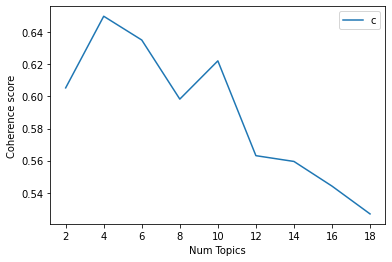

Num Topics = 2  has Coherence Value of 0.6053
Num Topics = 4  has Coherence Value of 0.6499
Num Topics = 6  has Coherence Value of 0.6351
Num Topics = 8  has Coherence Value of 0.5983
Num Topics = 10  has Coherence Value of 0.6221
Num Topics = 12  has Coherence Value of 0.5631
Num Topics = 14  has Coherence Value of 0.5595
Num Topics = 16  has Coherence Value of 0.5441
Num Topics = 18  has Coherence Value of 0.5268


In [389]:
cats_health_supplies_dictionary, cats_health_supplies_doc_term_matrix = vectorize(cats_health_supplies_reviews2)
cats_health_supplies_model_list, coherence_values = compute_coherence_values(dictionary=cats_health_supplies_dictionary, 
                                                    corpus=cats_health_supplies_doc_term_matrix, 
                                                    texts=cats_health_supplies_reviews2, 
                                                    start=2, 
                                                    limit=20, 
                                                    step=2)

limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    
with open ('./cats_health_supplies_model_list.pickle', 'wb') as handle:
     pickle.dump(cats_health_supplies_model_list, handle)

In [391]:
cats_health_supplies_optimal_model = cats_health_supplies_model_list[1]
model_topics = optimal_model.show_topics(formatted=False)

keywords_dict = get_keywords(cats_health_supplies_doc_term_matrix, model = cats_health_supplies_optimal_model)
cats_health_supplies_optimal_model.print_topics(num_topics=4, num_words=30)

[(0,
  '0.020*"calm" + 0.020*"get" + 0.016*"seem" + 0.015*"use" + 0.015*"feliway" + 0.015*"try" + 0.013*"spray" + 0.013*"help" + 0.013*"go" + 0.012*"new" + 0.010*"work" + 0.010*"also" + 0.009*"well" + 0.009*"think" + 0.009*"still" + 0.009*"come" + 0.008*"see" + 0.008*"start" + 0.008*"old" + 0.008*"make" + 0.007*"plug" + 0.007*"say" + 0.007*"really" + 0.007*"buy" + 0.007*"even" + 0.006*"much" + 0.006*"keep" + 0.006*"move" + 0.006*"stop" + 0.006*"little"'),
 (1,
  '0.038*"eat" + 0.024*"give" + 0.014*"try" + 0.013*"good" + 0.012*"seem" + 0.011*"take" + 0.010*"even" + 0.010*"treat" + 0.010*"daily" + 0.009*"love" + 0.008*"small" + 0.008*"think" + 0.008*"little" + 0.008*"get" + 0.007*"say" + 0.007*"also" + 0.007*"make" + 0.007*"recommend" + 0.007*"well" + 0.007*"much" + 0.007*"use" + 0.006*"help" + 0.006*"see" + 0.006*"large" + 0.006*"healthy" + 0.006*"look" + 0.006*"want" + 0.005*"dry" + 0.005*"picky" + 0.005*"first"'),
 (2,
  '0.044*"get" + 0.037*"work" + 0.030*"use" + 0.030*"well" + 0.022

In [393]:
[w for w in keywords_dict[0] if w not in  keywords_dict[1]\
                                and w not in  keywords_dict[2]\
                                and w not in  keywords_dict[3]]  

['calm', 'feliway', 'spray', 'new', 'still', 'old']

In [394]:
[w for w in keywords_dict[1] if w not in  keywords_dict[0]\
                                and w not in  keywords_dict[2]\
                                and w not in  keywords_dict[3]]  

['eat', 'treat', 'daily', 'love', 'small', 'little', 'recommend']

In [395]:
[w for w in keywords_dict[2] if w not in  keywords_dict[1]\
                                and w not in  keywords_dict[0]\
                                and w not in  keywords_dict[3]]  

['really', 'great', 'sure', 'keep', 'clean', 'easy', 'know']

In [396]:
[w for w in keywords_dict[3] if w not in  keywords_dict[1]\
                                and w not in  keywords_dict[2]\
                                and w not in  keywords_dict[0]]  

['put', 'back', 'find', 'need', 'never', 'long', 'apply']

In [392]:
pyLDAvis.enable_notebook()
topic_data =  pyLDAvis.gensim_models.prepare(cats_health_supplies_optimal_model, 
                                             cats_health_supplies_doc_term_matrix, 
                                             cats_health_supplies_dictionary, 
                                             mds = 'tsne')
pyLDAvis.display(topic_data)

C:\Users\JiatingChen\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
C:\Users\JiatingChen\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


## 7. cats treats

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

Round: 2
Round: 4
Round: 6
Round: 8
Round: 10
Round: 12
Round: 14
Round: 16
Round: 18


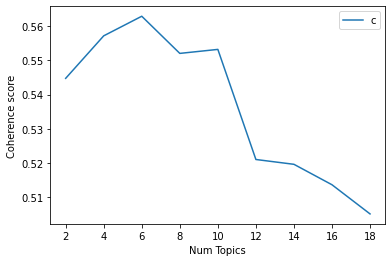

Num Topics = 2  has Coherence Value of 0.5448
Num Topics = 4  has Coherence Value of 0.5572
Num Topics = 6  has Coherence Value of 0.5629
Num Topics = 8  has Coherence Value of 0.552
Num Topics = 10  has Coherence Value of 0.5532
Num Topics = 12  has Coherence Value of 0.5211
Num Topics = 14  has Coherence Value of 0.5197
Num Topics = 16  has Coherence Value of 0.5137
Num Topics = 18  has Coherence Value of 0.5052


FileNotFoundError: [Errno 2] No such file or directory: './cat_treats_model_list.pickle'

In [399]:
cats_treats_dictionary, cats_treats_doc_term_matrix = vectorize(cats_treats_reviews2)
cat_treats_model_list, coherence_values = compute_coherence_values(dictionary=cats_treats_dictionary, 
                                                    corpus=cats_treats_doc_term_matrix, 
                                                    texts=cats_treats_reviews2, 
                                                    start=2, 
                                                    limit=20, 
                                                    step=2)

limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    
with open ('./cat_treats_model_list.pickle', 'rb') as handle:
     pickle.dump(cat_treats_model_list, handle)

In [ ]:
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)

optimal_model.print_topics(num_topics=4, num_words=30)
keywords_dict = get_keywords(cats_treats_doc_term_matrix, model = optimal_model)

pyLDAvis.enable_notebook()
topic_data =  pyLDAvis.gensim_models.prepare(optimal_model, 
                                             cats_treats_doc_term_matrix, 
                                             cats_treats_dictionary, 
                                             mds = 'tsne')
pyLDAvis.display(topic_data)

## 8. cats grooming

In [ ]:
cats_grooming_dictionary, cats_grooming_doc_term_matrix = vectorize(cats_grooming_reviews2)
cats_grooming_model_list, coherence_values = compute_coherence_values(dictionary=cats_grooming_dictionary, 
                                                    corpus=cats_grooming_doc_term_matrix, 
                                                    texts=cats_grooming_reviews, 
                                                    start=2, 
                                                    limit=20, 
                                                    step=2)

limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    
    
with open ('./cat_treats_model_list.pickle', 'rb') as handle:
     pickle.dump(model_list, handle)

In [ ]:
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)

optimal_model.print_topics(num_topics=4, num_words=30)
keywords_dict = get_keywords(cats_food_doc_term_matrix, model = optimal_model)

pyLDAvis.enable_notebook()
topic_data =  pyLDAvis.gensim_models.prepare(optimal_model, 
                                             cats_food_doc_term_matrix, 
                                             cats_food_dictionary, 
                                             mds = 'tsne')
pyLDAvis.display(topic_data)